In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/딥러닝 파이토치 교과서/chap05/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/딥러닝 파이토치 교과서/chap05


# 5.2 합성곱 신경망 맛보기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# [1] fashionMNIST(다운받기)

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST("FashionMNIST/",
                                                  download = True,
                                                  train = True,
                                                  transform = transforms.Compose([transforms.ToTensor()]))

test_dataset = torchvision.datasets.FashionMNIST("FashionMNIST/",
                                                 download = True,
                                                 train = False,
                                                 transform = transforms.Compose([transforms.ToTensor()]))

# [2] Dataloader
* X와 Y를 배치단위로 전달해줌

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size = 100)
test_loader = DataLoader(test_dataset,
                         batch_size = 100)

In [ ]:
for i, j in train_loader:
  print(i.shape,j.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([1

# [3] fashionMNIST확인하기

In [ ]:
label_dict = {0 : 'T-Shirt',
              1 : 'Trouser',
              2 : 'Pullover',
              3 : 'Dress',
              4 : 'Coat',
              5 : 'Sandal',
              6 : 'Shirt',
              7 : 'Sneaker',
              8 : 'Bag',
              9 : 'AnkleBoot'}

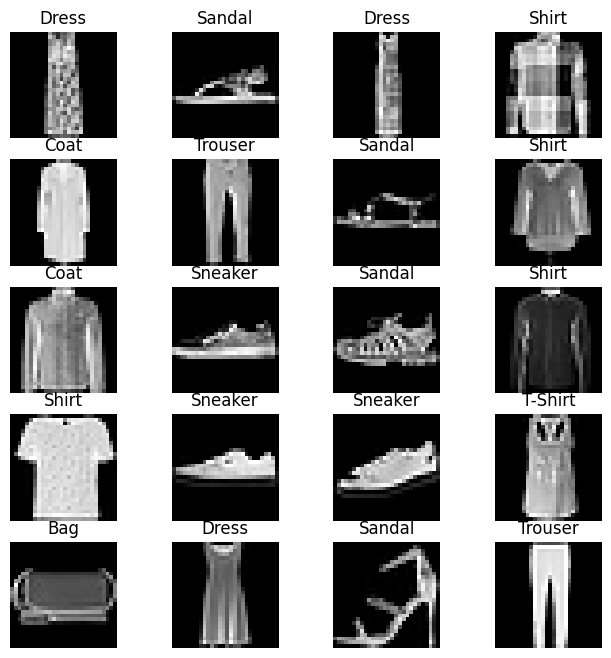

In [ ]:
fig = plt.figure(figsize = (8,8))
cols = 4
rows = 5

for i in range(1, cols*rows + 1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows,cols,i)
  plt.title(label_dict[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
print('train_dataset :',train_dataset,'\n')
print(len(train_dataset),'\n')
print('img_xy :',np.random.randint(len(train_dataset)))
print(train_dataset[3][0].shape)
print(train_dataset[3][0][0,:,:].shape)

train_dataset : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: FashionMNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

60000 

img_xy : 51022
torch.Size([1, 28, 28])
torch.Size([28, 28])


# [4] 선형분류모델 만들기

In [ ]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features = 28*28, out_features = 256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features = 256, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, input_data):
    x = input_data.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
lr = 0.001
model = FashionDNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []


for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    # 자동미분을 저장하기 위해 Variable에 저장
    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not(count % 50):
      '''
      학습 중에 test성능을 50반복수마다 모두 기록함
      '''
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels  = images.to(device), labels.to(device)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs,1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)
      accuracy = correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not(count % 500):
      print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")

Iteration : 500, Loss : 0.5735607147216797, Accuracy : 83.19999694824219
Iteration : 1000, Loss : 0.4561271369457245, Accuracy : 84.2699966430664
Iteration : 1500, Loss : 0.3220253884792328, Accuracy : 84.30999755859375
Iteration : 2000, Loss : 0.3557024896144867, Accuracy : 86.18000030517578
Iteration : 2500, Loss : 0.2723396420478821, Accuracy : 86.19999694824219
Iteration : 3000, Loss : 0.2781877815723419, Accuracy : 86.93000030517578


In [ ]:
print(train_dataset)
# 1epoch에 600번 반복 > 600/50 = 12 > 12*5 = 60
# 전체 iteration 600 * 5 = 3000
print(test_dataset)
# 1epoch에 100번 반복

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: FashionMNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: FashionMNIST/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
print(len(iteration_list))
print(len(loss_list))

60
60


# [5] CNN 만들기

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),  # 정규화
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2) # 연산량 감소 + 주요한 특성벡터 추출
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features = 64*6*6, out_features = 600)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.fc3 = nn.Linear(in_features = 120, out_features = 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1) # Flatten()
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
lr = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

In [ ]:
import time
start_time = time.time()

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not(count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs,1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)
      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)
    if not(count % 500):
      print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")

end_time = time.time()
print(f'총 소요시간 : {end_time - start_time}')

Iteration : 500, Loss : 0.5394618511199951, Accuracy : 87.41999816894531
Iteration : 1000, Loss : 0.30007484555244446, Accuracy : 87.66999816894531
Iteration : 1500, Loss : 0.31429603695869446, Accuracy : 88.08999633789062
Iteration : 2000, Loss : 0.20671580731868744, Accuracy : 89.20999908447266
Iteration : 2500, Loss : 0.17326384782791138, Accuracy : 89.75
Iteration : 3000, Loss : 0.16455522179603577, Accuracy : 90.32999420166016
총 소요시간 : 114.9472246170044


# 5.3.1 전이학습
* 아주 큰 데이터셋을 이용해서 훈련된 모델의 가중치를 가져와 사용
* [1] 특성 추출
* [2] 미세 조정

# [1] 특성 추출
* 사전 훈련된 모델을 가져와 마지막의 완전연결층을 새로 만드는 방식

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

* dataset 호출하기

In [25]:
# data_path = '/content/drive/MyDrive/딥러닝 파이토치 교과서/chap05/data/catanddog/train'
data_path = 'data/catanddog/train'
transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        ]
)

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True
)

print(len(train_dataset))

385


* 이미지 확인하기

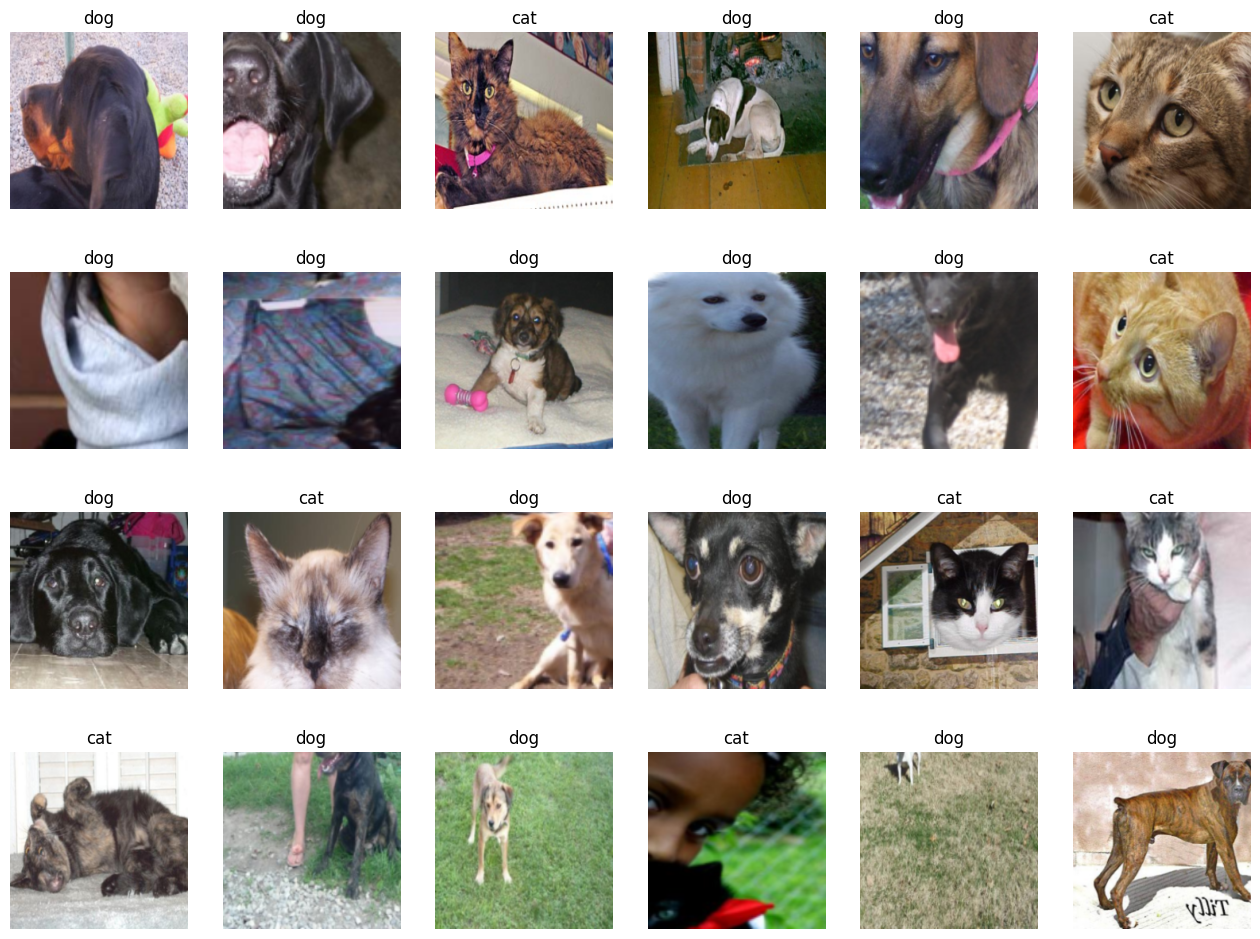

In [ ]:
import numpy as np

# 책코드
# samples, labels = iter(train_loader).next() -> 오류발생
# 파이토치 최신버전은 next(iter(train_loader))로 사용
# iter : for문과 비슷한 효과
# [이미지 텐서], [클래스 라벨]
# 1배치에 대해 수행함
samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1 : 'dog'}

fig = plt.figure(figsize = (16,24))

for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  # pytorch, opencv : (D,W,H) -> matpotlib : (W,H,D)
  # 차원변환
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

In [ ]:
# 배치에대해 수행한 것을 확인할 수 있음
len(labels)

32

# [1-2] 가중치 사용O VS 가중치 사용X
* ex)
* 가중치사용O : googlenet = torchvision.models.googlenet(pretrained = True)
* 가중치사용X : googlenet = torchvision.models.googlenet(pretrained = False)

# [1-3] ResNet18 간단하게 살펴보기
* torchvision.models.resnet18
* 50개의 계층으로 구성된 합성곱신경망
* ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망

In [ ]:
# resnet 호출하기
resnet18 = models.resnet18(pretrained = True)

# 사전 훈련된 모델의 파라미터 학습 유무지정
# 다음 함수를 이용하여 학습이되지않도록함
def set_parameter_requires_grad(model, feature_extracting = True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

# 역전파 중 파라미터계산X
set_parameter_requires_grad(resnet18)

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 마지막 레이어인 fc는 512를 받고 1000개의 클래스를 분류하였지만
# 본 데이터에서는 2개만 분류하면 되므로 fc층을 수정해줌
resnet18.fc = nn.Linear(512,2)

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델의 파라미터값 확인
for name, param in resnet18.named_parameters():
  if param.requires_grad:
  # param.requires_grad가 True인 fc층만 파라미터를 보여줌
    print(name, param.data)

fc.weight tensor([[-0.0271, -0.0008, -0.0238,  ...,  0.0188, -0.0166, -0.0167],
        [ 0.0061,  0.0107, -0.0223,  ...,  0.0004, -0.0431, -0.0346]])
fc.bias tensor([ 0.0128, -0.0125])


# [1-4] ResNet18 학습시키기
* model = models.resnet18(pretrained = True)는 삭제예정임
* model = models.resnet18(weights = 'ResNet18_Weights.IMAGENET1K_V1')로 사용해야함

In [22]:
model = models.resnet18(pretrained = True)
for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Linear(512,2)
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* 모델학습을 위한 함수생성

In [23]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
  start_time = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs, labels = inputs.to(device), labels.to(device)
      model.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs,1)

      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects / len(dataloaders.dataset)

    print(f'Loss : {epoch_loss}, Acc : {epoch_acc}')

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(),f'resnet18(epoch = {epoch}).pth')
    print()

  spend_time = time.time() - start_time
  print(f'Training complete in {spend_time//60}min {spend_time % 60}second')
  print(f'Best Acc : {best_acc}')
  return acc_history, loss_history

In [26]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print('\t', name)

# optimizer = optim.Adam(mdoel.parameters(), lr = lr)
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [27]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(model = model,
                                              dataloaders = train_loader,
                                              criterion = criterion,
                                              optimizer = optimizer,
                                              device = device)

Epoch 0/12
----------
Loss : 0.6807741812297277, Acc : 0.5740259885787964

Epoch 1/12
----------
Loss : 0.45756990259343927, Acc : 0.7714285850524902

Epoch 2/12
----------
Loss : 0.36720870222364155, Acc : 0.8207792043685913

Epoch 3/12
----------
Loss : 0.27039925370897566, Acc : 0.8987013101577759

Epoch 4/12
----------
Loss : 0.2723037741400979, Acc : 0.8909090757369995

Epoch 5/12
----------
Loss : 0.270272569377701, Acc : 0.8727272748947144

Epoch 6/12
----------
Loss : 0.20732943671090262, Acc : 0.9298701286315918

Epoch 7/12
----------
Loss : 0.25181746993746074, Acc : 0.8961038589477539

Epoch 8/12
----------
Loss : 0.20542235978237994, Acc : 0.9272727370262146

Epoch 9/12
----------
Loss : 0.21393022970719772, Acc : 0.9142857193946838

Epoch 10/12
----------
Loss : 0.2240563962366674, Acc : 0.9064934849739075

Epoch 11/12
----------
Loss : 0.2129126366082724, Acc : 0.8987013101577759

Epoch 12/12
----------
Loss : 0.21485517915193136, Acc : 0.9090908765792847

Training comple

# [1-5] ResNet18 테스트데이터 평가

In [28]:
%pwd

'/content/drive/MyDrive/딥러닝 파이토치 교과서/chap05'

In [29]:
test_path = 'data/catanddog/test'
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

print(len(test_dataset))

98


In [45]:
# 테스트 데이터 평가함수

def eval_model(model, dataloaders, device):
  start_time = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('*.pth')
  print('save_model',saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs, labels = inputs.to(device), labels.to(device)

      with torch.no_grad():
        outputs = model(inputs)

      _,preds = torch.max(outputs.data, 1)
      preds[preds >= 0.5] = 1
      preds[preds < 0.5] = 0
      running_corrects += preds.eq(labels).int().sum()

    epoch_acc = running_corrects / len(dataloaders.dataset)
    print(f'Acc : {epoch_acc}')

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    print()

  spend_time = time.time() - start_time
  print(f'Test complete in {spend_time//60}min {spend_time % 60}sec')
  print(f'Best Acc : {best_acc}')
  return acc_history

In [40]:
glob_list = glob.glob('*.pth')
glob_list

['resnet18(epoch = 0).pth',
 'resnet18(epoch = 1).pth',
 'resnet18(epoch = 2).pth',
 'resnet18(epoch = 3).pth',
 'resnet18(epoch = 4).pth',
 'resnet18(epoch = 5).pth',
 'resnet18(epoch = 6).pth',
 'resnet18(epoch = 7).pth',
 'resnet18(epoch = 8).pth',
 'resnet18(epoch = 9).pth',
 'resnet18(epoch = 10).pth',
 'resnet18(epoch = 11).pth',
 'resnet18(epoch = 12).pth']

In [46]:
test_acc_hist = eval_model(model = model,
                           dataloaders = test_loader,
                           device = device)

save_model ['resnet18(epoch = 0).pth', 'resnet18(epoch = 1).pth', 'resnet18(epoch = 2).pth', 'resnet18(epoch = 3).pth', 'resnet18(epoch = 4).pth', 'resnet18(epoch = 5).pth', 'resnet18(epoch = 6).pth', 'resnet18(epoch = 7).pth', 'resnet18(epoch = 8).pth', 'resnet18(epoch = 9).pth', 'resnet18(epoch = 10).pth', 'resnet18(epoch = 11).pth', 'resnet18(epoch = 12).pth']
Loading model resnet18(epoch = 0).pth
Acc : 0.7755101919174194

Loading model resnet18(epoch = 1).pth
Acc : 0.8367346525192261

Loading model resnet18(epoch = 2).pth
Acc : 0.9285714030265808

Loading model resnet18(epoch = 3).pth
Acc : 0.9387754797935486

Loading model resnet18(epoch = 4).pth
Acc : 0.9489795565605164

Loading model resnet18(epoch = 5).pth
Acc : 0.9387754797935486

Loading model resnet18(epoch = 6).pth
Acc : 0.9489795565605164

Loading model resnet18(epoch = 7).pth
Acc : 0.9387754797935486

Loading model resnet18(epoch = 8).pth
Acc : 0.9591836333274841

Loading model resnet18(epoch = 9).pth
Acc : 0.959183633327

* 정확도 그래프


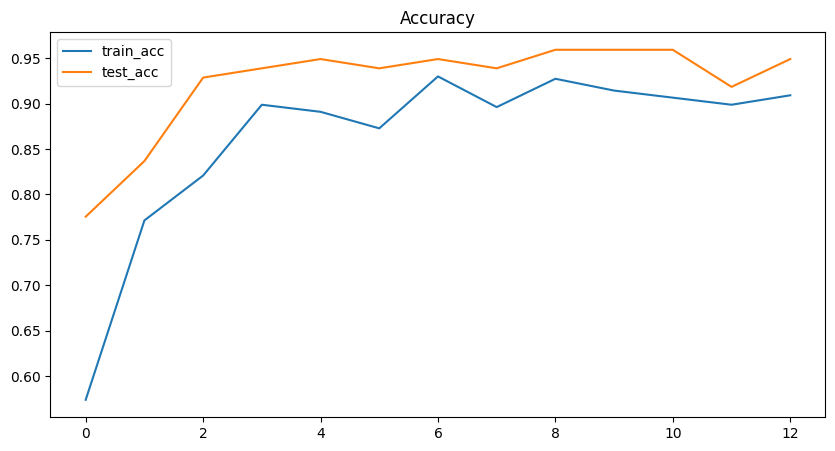

In [51]:
plt.figure(figsize = (10,5))
plt.title('Accuracy')
plt.plot(train_acc_hist, label = 'train_acc')
plt.plot(test_acc_hist, label = 'test_acc')
plt.legend(loc = 'best')
plt.show()

* 훈련loss그래프확인하기

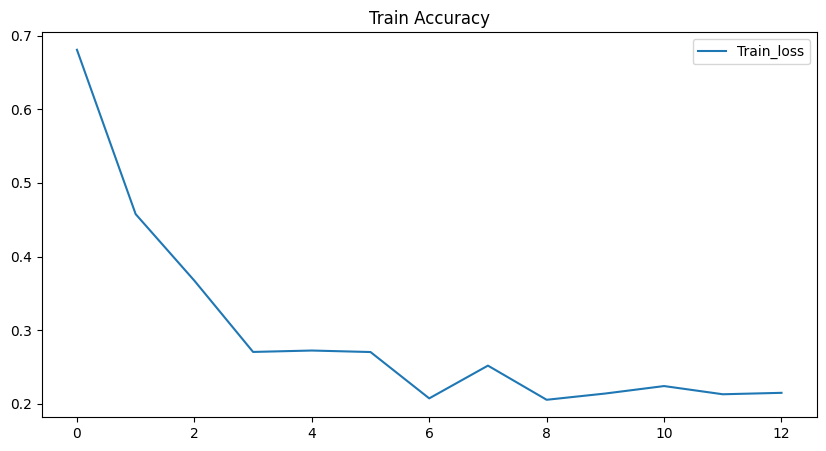

In [53]:
plt.figure(figsize = (10,5))
plt.title('Train Accuracy')
plt.plot(train_loss_hist, label = 'Train_loss')
plt.legend(loc = 'best')
plt.show()

* 모델 예측이미지 확인하기

In [54]:
# 이미지전처리 함수
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  # 기존 텐서를 복사하여 기울기가 전파되지 않도록 detatch를 수행한 후 넘파이로 변환
  image = image.transpose(1,2,0)
  # matplotlib 형식으로 변환 (W,H,D)
  image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))) # ??
  image = image.clip(0,1)
  # 값들을 0~1사이로 제한함
  return image

In [55]:
print(np.array((0.5,0.5,0.5)))
print(np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))

[0.5 0.5 0.5]
[1. 1. 1.]


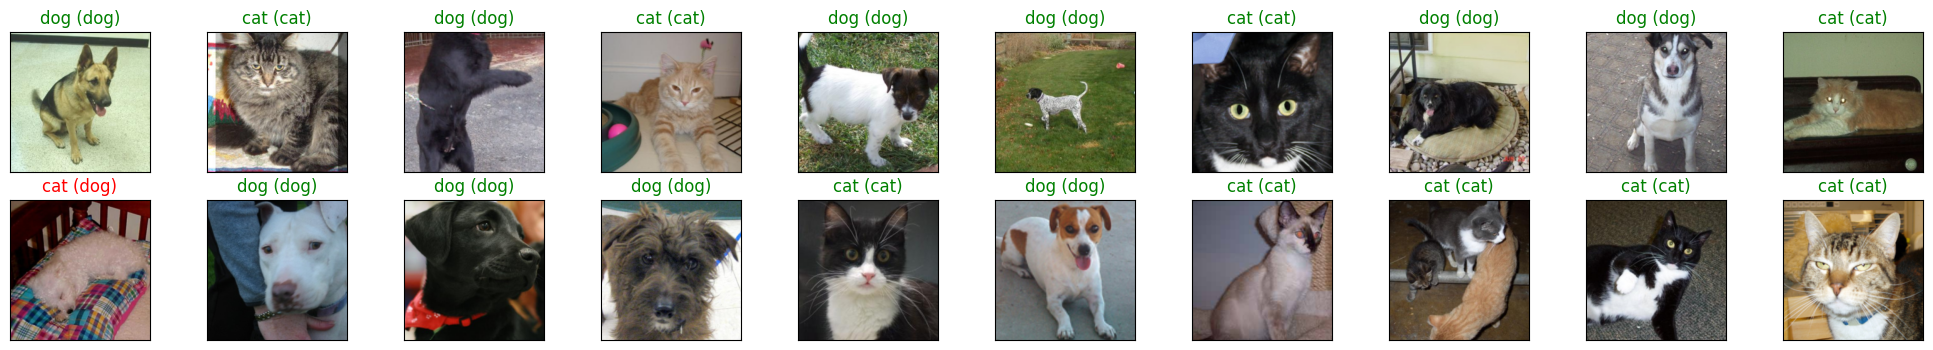

<Figure size 640x480 with 0 Axes>

In [59]:
# pred(label)

classes = {0 : 'cat', 1 : 'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images.to(device))
_,preds = torch.max(output,1)

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[i].item()])
  ax.set_title("{} ({})".format(
    str(classes[preds[idx].item()]),
    str(classes[labels[idx].item()])),
    color = ("green" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

# 5.3.2 미세조정기법
* 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우 [모델 전체를 재학습]
* 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우   [합성곱층의 끝단부터 재학습]
* 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우 [합성곱층의 끝단부터 재학습]
* 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우   [fc만 학습시켜도됨 == 미세조정]

# 5.4 설명가능한 CNN
* __특성맵 시각화__, 커널시각화
* 특성맵은 커널을 거친 결과임

In [61]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor, transforms
import torchvision
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
# 설명 가능한 네트워크?

class XAI(nn.Module):
  def __init__(self, num_classes = 2):
    super(XAI, self).__init__()

    self.features = nn.Sequential(
        # 1(2-stage)
        nn.Conv2d(3,64,kernel_size = 3, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.Dropout(0.3),

        nn.Conv2d(64,64,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        # 2(2-stage)
        nn.Conv2d(64,128,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),

        nn.Conv2d(128,128,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        # 3(3-stage)
        nn.Conv2d(128,256,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),

        nn.Conv2d(256,256,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),

        nn.Conv2d(256,256,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        # 4(3-stage)
        nn.Conv2d(256,512,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),

        nn.Conv2d(512,512,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),

        nn.Conv2d(512,512,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        # 5(3-stage)
        nn.Conv2d(512,512,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),

        nn.Conv2d(512,512,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),

        nn.Conv2d(512,512,kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    )
    self.classifier = nn.Sequential(
        nn.Linear(512,512,bias = False),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(-1,512)
    x = self.classifier(x)
    return F.log_softmax(x)

In [106]:
model = XAI()
model.cpu()
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [107]:
# 특성 맵을 확인하기위한 클래스 정의
# pytorch는 print를 사용하지 않더라도 hook을 사용하여
# 각 계층의 활성화함수 및 기울기 값 확인

class LayerActivations:
  features = []
  def __init__(self, model, layer_num):
    self.hook = model[layer_num].register_forward_hook(self.hook_fn)


  def hook_fn(self, module, input, output):
    output = output
    self.features = output.detach().numpy()

  def remove(self):
    self.hook.remove()

torch.Size([1, 3, 100, 100])


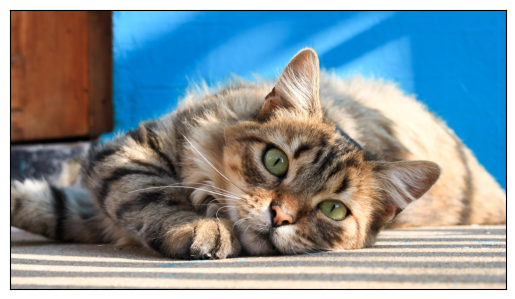

In [108]:
# 고양이사진 실험
img = cv2.imread('data/cat.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

* 0번째 Conv2d 특성맵 확인

In [109]:
img = cv2.imread('data/cat.jpg')
img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

<ipython-input-73-0231754583d7>:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


* 0번째 특성맵

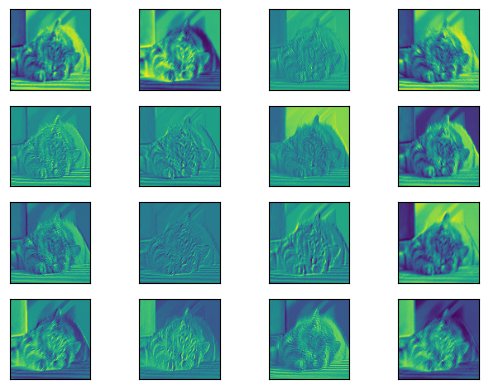

<Figure size 1200x800 with 0 Axes>

In [110]:
result = LayerActivations(model.features, 0)
model(img)
activations = result.features

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize = (12,8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row * 10 + column])
plt.show()

* 20번째 특성맵

<ipython-input-73-0231754583d7>:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


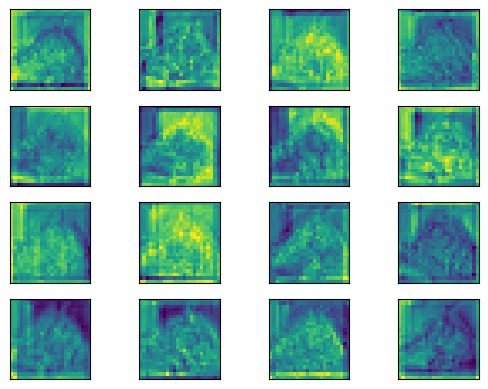

<Figure size 1200x800 with 0 Axes>

In [111]:
result = LayerActivations(model.features, 20)
model(img)
activations = result.features

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize = (12,8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row * 10 + column])
plt.show()

* 40번째 특성맵확인

<ipython-input-73-0231754583d7>:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


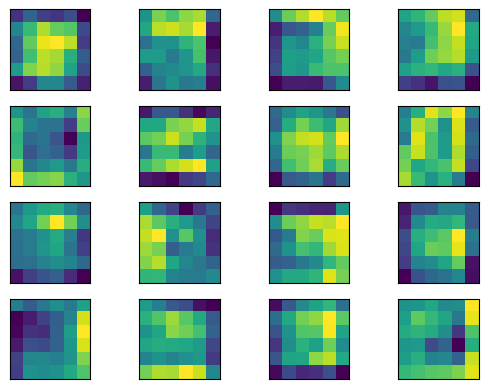

<Figure size 1200x800 with 0 Axes>

In [112]:
result = LayerActivations(model.features, 40)
model(img)
activations = result.features

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize = (12,8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row * 10 + column])
plt.show()